<a href="https://colab.research.google.com/github/mtunahanyollar/MS-COCO-ImageProcess/blob/main/Bitirme2v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Ola

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os 
import sys
from pycocotools.coco import COCO
import urllib
import zipfile 

In [ ]:
os.makedirs('opt' , exist_ok=True)
os.chdir( '/content/opt' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 1.48 MiB/s, done.
Resolving deltas: 100% (576/576), done.


Download the Annotations and Captions :

In [ ]:
os.chdir('/content/opt/cocoapi')

# Download the annotation : 
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )

('image_info_test2014.zip', <http.client.HTTPMessage at 0x7fb881eff0b8>)

Extract Annotations from ZIP file

In [ ]:
with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'annotations_trainval2014.zip' )
  print('zip silindi')
except:
  None

with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'image_info_test2014.zip' )
  print('zip silindi')
except:
  None

zip silindi
zip silindi


Initialize and verify the loaded data

In [ ]:
!ls {cocoapi}

ls: cannot access '{cocoapi}': No such file or directory


In [ ]:
os.chdir('/content/opt/cocoapi/annotations')
dataType = 'val2014'
instances_annFile = 'instances_{}.json'.format(dataType)
print(instances_annFile)
coco = COCO(instances_annFile)

captions_annFile = 'captions_{}.json'.format(dataType)
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

instances_val2014.json
loading annotations into memory...
Done (t=5.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


plot a sample Image

In [ ]:
import matplotlib.pyplot as plt 
import skimage.io as io 
import numpy as np 
%matplotlib inline 

http://images.cocodataset.org/val2014/COCO_val2014_000000115830.jpg
İlgili gorsel icin aciklamalarının dizi karsiligi:  [421989, 422919, 423441, 423642, 424422]

A person at a table with a bowl of food.
A man that is sitting at a table with a bowl.
A man is eating food in a bowl
A man has a spoon in a large bowl.
The man is smiling and eating food with chopsticks. 


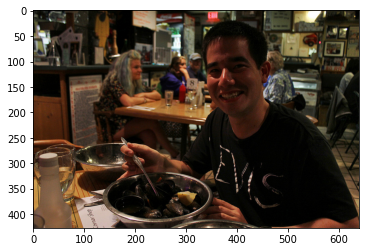

In [ ]:
ann_id = np.random.choice( ids )
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs( img_id )[0]
url = img['coco_url']
print(url)
I = io.imread(url)
plt.imshow(I)

ann_ids = coco_caps.getAnnIds( img_id   )
print('İlgili gorsel icin aciklamalarının dizi karsiligi: ' , ann_ids)
print()
anns = coco_caps.loadAnns( ann_ids )
coco_caps.showAnns(anns)

Download Train , Test , Val Images :

In [ ]:
os.chdir('/content/opt/cocoapi')

train2014 = 'http://images.cocodataset.org/zips/train2014.zip'
test2014 = 'http://images.cocodataset.org/zips/test2014.zip'
val2014 = 'http://images.cocodataset.org/zips/val2014.zip'

urllib.request.urlretrieve( train2014 , 'train2014' )
urllib.request.urlretrieve( test2014 , 'test2014' )
#urllib.request.urlretrieve( val2014 , 'val2014' )


('test2014', <http.client.HTTPMessage at 0x7fb84ac5a780>)

unzip the download image zip files 

In [ ]:
os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'train2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'train2014' )
  print('zip removed')
except:
  None


os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'test2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'test2014' )
  print('zip removed')
except:
  None

zip removed
zip removed


## Step1 Explore the DataLoader

### Vocabulary.py

In [ ]:
# vocabulary.py -------------------------------------------------------------
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2014.json',  #Locale
        vocab_from_file=False):
      
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary yuklendi')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenlestirilen, captions" % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

### data_loader.py

In [ ]:
# Data Loader ---------------------------------------------------------------------------------------------

import nltk
import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json

def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):
 
    assert mode in ['train', 'test'], "."
    if vocab_from_file==False: assert mode=='train', "asd"

    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vasd."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
    if mode == 'test':
        assert batch_size==1, "."
        assert os.path.exists(vocab_file), "."
        assert vocab_from_file==True, "."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        indices = dataset.get_train_indices()
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':            
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            
            return image, caption

       
        else:
            path = self.paths[index]
            
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

### Dataloader creation

In [ ]:
import sys
from pycocotools.coco import COCO
!pip install nltk
import nltk
nltk.download('punkt')
from torchvision import transforms


transform_train = transforms.Compose([ 
    transforms.Resize(256),                         
    transforms.RandomCrop(224),                      
    transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

vocab_threshold = 8

batch_size = 200

data_loader_train = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         cocoapi_loc = '/content/opt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
loading annotations into memory...
Done (t=2.47s)
creating index...
index created!
[0/414113] Tokenlestirilen, captions
[100000/414113] Tokenlestirilen, captions
[200000/414113] Tokenlestirilen, captions
[300000/414113] Tokenlestirilen, captions
[400000/414113] Tokenlestirilen, captions
loading annotations into memory...
Done (t=0.69s)
creating index...


  0%|          | 774/414113 [00:00<00:53, 7738.97it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:56<00:00, 7288.02it/s]


In [ ]:
import torch 
import numpy as np 
import torch.utils.data as data

In [ ]:
sample_caption = 'Who wants to pass this class successfully with A. Kim bu dersi AA ile gecmek ister'
sample_tokens = nltk.tokenize.word_tokenize( sample_caption.lower() )

sample_caption = []
start_word  = data_loader_train.dataset.vocab.start_word
end_word = data_loader_train.dataset.vocab.end_word
sample_tokens.insert(0 , start_word)
sample_tokens.append(end_word)
sample_caption.extend( [ data_loader_train.dataset.vocab(token) for token in sample_tokens ] )


sample_caption = torch.Tensor( sample_caption ).long()
print('Ornek Cumle Icın Kelime IDs:' , '\n')
print(sample_tokens) 
print(sample_caption )

print('Cumle Index: \n')
print('Start idx {} , End idx {} , unknown idx {}'.format( 0,1,2 ))

Ornek Cumle Icın Kelime IDs: 

['<start>', 'who', 'wants', 'to', 'pass', 'this', 'class', 'successfully', 'with', 'a.', 'kim', 'bu', 'dersi', 'aa', 'ile', 'gecmek', 'ister', '<end>']
tensor([   0,  502, 4223,  159, 2645,  143, 4712, 6868,   21,    2,    2,    2,
           2, 2357,    2,    2,    2,    1])
Cumle Index: 

Start idx 0 , End idx 1 , unknown idx 2


In [ ]:
print('Vocab Kelimeler' , dict(list(data_loader_train.dataset.vocab.word2idx.items())[:30]))
print('Totaltokens Vocab:', len(data_loader_train.dataset.vocab))

Vocab Kelimeler {'<start>': 0, '<end>': 1, '<unk>': 2, 'a': 3, 'very': 4, 'clean': 5, 'and': 6, 'well': 7, 'decorated': 8, 'empty': 9, 'bathroom': 10, 'panoramic': 11, 'view': 12, 'of': 13, 'kitchen': 14, 'all': 15, 'its': 16, 'appliances': 17, '.': 18, 'blue': 19, 'white': 20, 'with': 21, 'butterfly': 22, 'themed': 23, 'wall': 24, 'tiles': 25, 'photo': 26, 'dining': 27, 'room': 28, 'stop': 29}
Totaltokens Vocab: 7073


<a id='step2'></a>
## Step 2: Use the Data Loader to Obtain Batches


In [ ]:
from collections import Counter

counter = Counter(data_loader_train.dataset.caption_lengths)
lengths = sorted( counter.items() , key = lambda pair : pair[1] , reverse=True )
for val,count in lengths:
  print( 'Kelime Adet %2d  Imaj %5d' %(val,count) )
  if count < 10000: 
    break

Kelime Adet 10  Imaj 86334
Kelime Adet 11  Imaj 79948
Kelime Adet  9  Imaj 71934
Kelime Adet 12  Imaj 57637
Kelime Adet 13  Imaj 37645
Kelime Adet 14  Imaj 22335
Kelime Adet  8  Imaj 20771
Kelime Adet 15  Imaj 12841
Kelime Adet 16  Imaj  7729


In [ ]:
indices = data_loader_train.dataset.get_train_indices()
print('Ornek Indices:' , indices )

sampler = data.sampler.SubsetRandomSampler(  indices )
data_loader_train.batch_sampler.sampler = sampler 

images , captions = next(iter(data_loader_train))
print(images.shape , captions.shape)

Ornek Indices: [39995, 131974, 286707, 377572, 54859, 274799, 32765, 41611, 233849, 324352, 382590, 391160, 148471, 349485, 98572, 934, 30278, 83993, 382767, 141829, 269096, 225077, 49292, 77021, 360682, 225311, 344499, 211903, 74754, 382, 240519, 231471, 320147, 345328, 155025, 293967, 326346, 192534, 247286, 23687, 349310, 402483, 62644, 303406, 124477, 233866, 324248, 379310, 177730, 363916, 34830, 357916, 166047, 190219, 264389, 310183, 121295, 279805, 258952, 78931, 407369, 1172, 205740, 109965, 14680, 205233, 149291, 59173, 137439, 321783, 1507, 339192, 19123, 29760, 196021, 312121, 63426, 39739, 354756, 345616, 336491, 105799, 125049, 401778, 28604, 300278, 142114, 142591, 288309, 162944, 247692, 293491, 348815, 323482, 185163, 304643, 387723, 142435, 385822, 114045, 284539, 339903, 197311, 21559, 372127, 93136, 249811, 332208, 327949, 150629, 247585, 18014, 95509, 305723, 194162, 233244, 402846, 328404, 141577, 180436, 38530, 308709, 281610, 320944, 278652, 67548, 204703, 21365

<a id='step3'></a>
## Step 3: CNN Encoder






In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)        
        features = features.view(features.size(0), -1)        
        features = self.embed(features)        
        return features
    

In [ ]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Localll
embed_size = 256 
encoder = EncoderCNN( embed_size )
encoder.to(device)
images=  images.to(device) # images from step2 
features = encoder(images)

print(type(features) , features.shape , images.shape)
assert( type(features) == torch.Tensor )  , 'Encoder output should be pytorch tensor'
assert (features.shape[0] == batch_size) & (features.shape[1] == embed_size) , "The shape of the encoder output is incorrect."

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



<class 'torch.Tensor'> torch.Size([200, 256]) torch.Size([200, 3, 224, 224])


<a id='step4'></a>
## Step 4: RNN Decoder




In [ ]:
import os 
import torch.utils.data as data 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math
import pickle
import matplotlib.pyplot as plt 
% matplotlib inline

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super( DecoderRNN , self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.word_embedding = nn.Embedding( self.vocab_size , self.embed_size )
        self.lstm  = nn.LSTM(    input_size  =  self.embed_size , 
                             hidden_size = self.hidden_size,
                             num_layers  = self.num_layers ,
                             batch_first = True 
                             )
        self.fc = nn.Linear( self.hidden_size , self.vocab_size  )
        

    def init_hidden( self, batch_size ):
      return ( torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device),
      torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )
    
    def forward(self, features, captions):            
      captions = captions[:,:-1]      
      self.batch_size = features.shape[0]
      self.hidden = self.init_hidden( self.batch_size )
      embeds = self.word_embedding( captions )
      inputs = torch.cat( ( features.unsqueeze(dim=1) , embeds ) , dim =1  )      
      lstm_out , self.hidden = self.lstm(inputs , self.hidden)      
      outputs = self.fc( lstm_out )      
      return outputs
    #DecoderRNN Predict'i
    def predict(self, inputs, max_len=20):        
        final_output = []
        batch_size = inputs.shape[0]         
        hidden = self.init_hidden(batch_size) 
    
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) 
            outputs = self.fc(lstm_out)  
            outputs = outputs.squeeze(1) 
            _, max_idx = torch.max(outputs, dim=1)
            final_output.append(max_idx.cpu().numpy()[0].item())             
            if (max_idx == 1 or len(final_output) >=20 ):
                break
            
            inputs = self.word_embedding(max_idx) 
            inputs = inputs.unsqueeze(1)             
        return final_output  

In [ ]:
embed_size = 256
hidden_size = 100
num_layers =1 
num_epochs = 4
print_every = 150
save_every = 1 
vocab_size = len(data_loader_train.dataset.vocab)
total_step = math.ceil( len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size   )

decoder = DecoderRNN(  embed_size , hidden_size, vocab_size ,num_layers)
criterion = nn.CrossEntropyLoss()
lr = 0.001
all_params = list(decoder.parameters())  + list( encoder.embed.parameters() )
optimizer = torch.optim.Adam( params  = all_params , lr = lr  )



device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/RNN_LSTM/image_caption/CVND---Image-Captioning-Project/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

# Save the params needed to created the model :
decoder_input_params = {'embed_size' : embed_size , 
                'hidden_size' : hidden_size , 
                'num_layers' : num_layers,
                'lr' : lr ,
                'vocab_size' : vocab_size
                }

with open(  os.path.join(model_save_path , 'decoder_input_params_12_20_2019.pickle'), 'wb') as handle:
    pickle.dump(decoder_input_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
"""import sys  SONRA GEL 
 for e in range(num_epochs):
  for step in range(total_step):
    indices = data_loader_train.dataset.get_train_indices()
    new_sampler = data.sampler.SubsetRandomSampler( indices )
    data_loader_train.batch_sampler.sampler = new_sampler    
    images,captions = next(iter(data_loader_train))    
    images , captions = images.to(device) , captions.to(device)
    encoder , decoder = encoder.to(device) , decoder.to(device)
    encoder.zero_grad()    
    decoder.zero_grad()
    features = encoder(images)
    output = decoder( features , captions )    
    loss = criterion( output.view(-1, vocab_size) , captions.view(-1) )
    loss.backward()
    optimizer.step()
    stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] ' %( e+1,num_epochs,step,total_step,loss.item() )
    if step % print_every == 0 :
      print(stat_vals)
      sys.stdout.flush()
    if e % save_every == 0:
      torch.save( encoder.state_dict() ,  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(e+1) ) )
      torch.save( decoder.state_dict() ,  os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(e+1) ) ) """"


SyntaxError: ignored

Load the saved checkpoint 

In [ ]:
model_save_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/RNN_LSTM/image_caption/CVND---Image-Captioning-Project/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(  os.path.join(model_save_path , 'decoder_input_params_12_20_2019.pickle'), 'rb') as handle:
    decoder_input_params = pickle.load(handle)

embed_size = decoder_input_params['embed_size']
hidden_size= decoder_input_params['hidden_size']
vocab_size = decoder_input_params['vocab_size']
num_layers = decoder_input_params['num_layers']

encoder = EncoderCNN( embed_size )
encoder.load_state_dict(   torch.load(  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(3) )   ) )

decoder = DecoderRNN( embed_size , hidden_size , vocab_size , num_layers )
decoder.load_state_dict( torch.load(   os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(3) )   ) )



<All keys matched successfully>

In [ ]:
os.listdir(model_save_path)

['encoderdata_2.pkl',
 'decoderdata_2.pkl',
 'encoderdata_3.pkl',
 'decoderdata_3.pkl',
 'encoderdata_4.pkl',
 'decoderdata_4.pkl',
 'decoderdata_1.pkl',
 'encoderdata_1.pkl',
 'decoder_input_params_12_20_2019.pickle']

In [ ]:
import sys

Create Dataloader for test data :

In [ ]:
from torchvision import transforms

transform_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.RandomCrop(224),                     
    transforms.RandomHorizontalFlip(),              
    transforms.ToTensor(),                          
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

# Obtain the data loader.
data_loader_test = get_loader(transform=transform_test,
                         mode='test',                         
                         cocoapi_loc = '/content/opt')

data_iter = iter(data_loader_test)

Vocabulary successfully loaded from vocab.pkl file!


In [ ]:
def get_sentences( original_img, all_predictions ):
  sentence = ' '
  plt.imshow(original_img.squeeze())
  return sentence.join([data_loader_test.dataset.vocab.idx2word[idx] for idx in all_predictions[1:-1] ]  )

Deneme E3: 


'a zebra standing in a field of grass .'

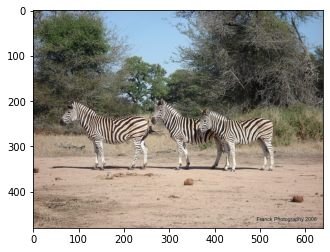

In [ ]:
encoder.to(device) 
decoder.to(device)
encoder.eval()
decoder.eval()
original_img , processed_img  = next( data_iter )
print('Deneme E3: ')
features  = encoder(processed_img.to(device)   ).unsqueeze(1)
final_output = decoder.predict( features  , max_len=20)
get_sentences(original_img, final_output)  